<a href="https://colab.research.google.com/github/iSarahSajjad/neuro-chronical-prediction/blob/Models/Final_Dataset_balanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


In [ ]:
import pandas as pd
import os

main_file_path = '/content/drive/My Drive/ChronicAI/dataset/participants.tsv'

# Read the TSV file into a DataFrame using pandas
main_df = pd.read_csv(main_file_path, sep='\t')

base_dir = '/content/drive/My Drive/ChronicAI/dataset/'

# Create a list to store the combined data
combined_data = []

# Keep only the specified columns
main_df = main_df[['participant_id', 'age', 'origin', 'group']]

# Iterate through each row in the main DataFrame
for index, row in main_df.iterrows():
    participant_id = row['participant_id']

    # Define the path to the participant's directory
    participant_dir = os.path.join(base_dir, str(participant_id))

    # Check if the directory exists
    if os.path.exists(participant_dir):
        # Get a list of all TSV files in the participant's directory
        tsv_files = [f for f in os.listdir(participant_dir) if f.endswith('.tsv')]

        # Iterate through each TSV file
        for tsv_file in tsv_files:
            tsv_file_path = os.path.join(participant_dir, tsv_file)

            # Read the TSV file into a DataFrame
            participant_df = pd.read_csv(tsv_file_path, sep='\t')

            # Add the participant's ID to the DataFrame
            participant_df['participant_id'] = participant_id

            # Append the DataFrame to the combined data list
            combined_data.append(participant_df)

# Combine all the DataFrames in the list into a single DataFrame
combined_df = pd.concat(combined_data, ignore_index=True)

# Merge the combined DataFrame with the main DataFrame on participant_id
final_df = pd.merge(main_df, combined_df, on='participant_id', how='left')

# Display the first few rows of the final DataFrame
print(final_df.head())

  participant_id  age origin     group session_id  days_since_interview  \
0        sub-001   27      4  subacute  interview                   0.0   
1        sub-001   27      4  subacute     visit1                   4.0   
2        sub-001   27      4  subacute     visit2                  94.0   
3        sub-001   27      4  subacute     visit3                   NaN   
4        sub-001   27      4  subacute     visit4                 395.0   

  hours_sleep smoker limited_self_care/mobility bdi_total  ...  pdi_total  \
0      6 to 7      n                          y       1.0  ...          2   
1      6 to 7      n                          n       NaN  ...         17   
2         NaN    NaN                        NaN       NaN  ...         21   
3           7      n                          n       7.0  ...          2   
4         NaN    NaN                        NaN       7.0  ...          2   

   pdetect_pain_now  pdetect_strongest_4wks pdetect_pain_average_4wks  \
0            

In [ ]:
output_csv_path = '/content/drive/My Drive/ChronicAI/dataset/final_df.csv'

# Ensure the directory for the output file exists
output_dir = os.path.dirname(output_csv_path)
os.makedirs(output_dir, exist_ok=True)

# Save the final DataFrame to a CSV file
final_df.to_csv(output_csv_path, index=False)

In [ ]:
import os
import pandas as pd
import numpy as np
import shutil

# Path to the main directory containing MRI data
base_dir = '/content/drive/My Drive/ChronicAI/dataset/'

# Path to save the balanced dataset
balanced_dataset_dir = '/content/drive/My Drive/ChronicAI/dataset/OptimizedDataset/'

# Ensure the balanced dataset directory exists
if not os.path.exists(balanced_dataset_dir):
    os.makedirs(balanced_dataset_dir)

# Load the final DataFrame
final_df = pd.read_csv('/content/drive/My Drive/ChronicAI/dataset/final_df.csv')

# Create a DataFrame to hold the count of .nii files per participant and session
file_counts = []

for _, row in final_df.iterrows():
    participant_id = row['participant_id']
    session_id = row['session_id']
    group = row['group']

    # Define the source directory of MRI files
    source_dir = os.path.join(base_dir, str(participant_id), f'ses-{session_id}', 'anat')

    if os.path.exists(source_dir):
        # Count the number of .nii files
        nii_files = [f for f in os.listdir(source_dir) if f.endswith('.nii')]
        file_counts.append({'participant_id': participant_id, 'session_id': session_id, 'group': group, 'file_count': len(nii_files)})
    else:
        print(f"Warning: Source directory {source_dir} does not exist for participant {participant_id}, session {session_id}.")

# Convert to DataFrame
file_counts_df = pd.DataFrame(file_counts)

# Print the total count of MRIs for each group
print("Total count of MRIs for each group:")
print(file_counts_df.groupby('group')['file_count'].sum())

# Define the target number of MRIs for each group
group_counts = file_counts_df.groupby('group')['file_count'].sum()
min_count = group_counts.min()

# Sample equal number of MRI records from each group
balanced_df = file_counts_df.groupby('group').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)

# Print the total count of MRIs for each group after balancing
print("\nTotal count of MRIs for each group after balancing:")
print(balanced_df.groupby('group')['file_count'].sum())



Total count of MRIs for each group:
group
chronic      87
healthy      80
subacute    267
Name: file_count, dtype: int64

Total count of MRIs for each group after balancing:
group
chronic     80
healthy     80
subacute    80
Name: file_count, dtype: int64


Total count of MRIs for each group:
group
chronic      87
healthy      80
subacute    267
Name: file_count, dtype: int64


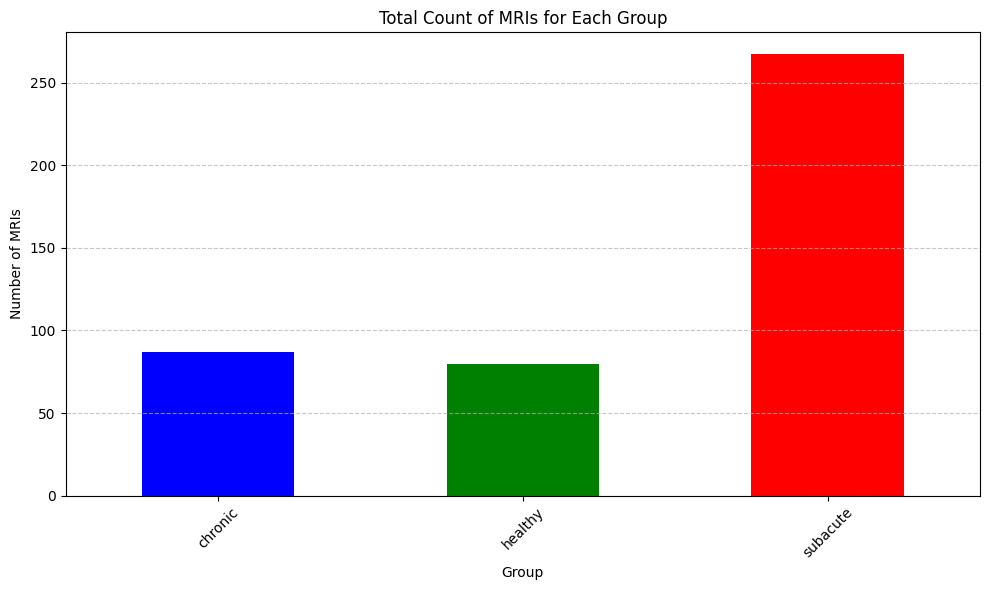

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Print the total count of MRIs for each group
print("Total count of MRIs for each group:")
total_counts = file_counts_df.groupby('group')['file_count'].sum()
print(total_counts)

# Plot the total count of MRIs for each group
plt.figure(figsize=(10, 6))
total_counts.plot(kind='bar', color=['blue', 'green', 'red'])
plt.title('Total Count of MRIs for Each Group')
plt.xlabel('Group')
plt.ylabel('Number of MRIs')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('/content/drive/My Drive/ChronicAI/dataset/mri_counts_by_group.png')
plt.show()


In [ ]:
import os
import pandas as pd
import numpy as np
import shutil
import nibabel as nib
from skimage import filters
from skimage.transform import resize
from skimage.exposure import equalize_hist
from skimage.restoration import denoise_bilateral

# Paths
base_dir = '/content/drive/My Drive/ChronicAI/dataset/'
balanced_dataset_dir = '/content/drive/My Drive/ChronicAI/dataset/OptimizedBalanceData/'

# Ensure the balanced dataset directory exists
if not os.path.exists(balanced_dataset_dir):
    os.makedirs(balanced_dataset_dir)

# Load the final DataFrame
final_df = pd.read_csv('/content/drive/My Drive/ChronicAI/dataset/final_df.csv')

# Create a DataFrame to hold the count of .nii files per participant and session
file_counts = []

for _, row in final_df.iterrows():
    participant_id = row['participant_id']
    session_id = row['session_id']
    group = row['group']

    # Define the source directory of MRI files
    source_dir = os.path.join(base_dir, str(participant_id), f'ses-{session_id}', 'anat')

    if os.path.exists(source_dir):
        # Count the number of .nii files
        nii_files = [f for f in os.listdir(source_dir) if f.endswith('.nii')]
        file_counts.append({'participant_id': participant_id, 'session_id': session_id, 'group': group, 'file_count': len(nii_files)})
    else:
        print(f"Warning: Source directory {source_dir} does not exist for participant {participant_id}, session {session_id}.")

# Convert to DataFrame
file_counts_df = pd.DataFrame(file_counts)

# Calculate the maximum count of MRIs for any group
max_count = file_counts_df['file_count'].max()

# Print the maximum count
print(f"Maximum count of MRIs for any group: {max_count}")

# Create a DataFrame to hold the balanced dataset
balanced_df = final_df.copy()

# Create a directory for each group within the balanced dataset
for group in balanced_df['group'].unique():
    group_dir = os.path.join(balanced_dataset_dir, group)
    if not os.path.exists(group_dir):
        os.makedirs(group_dir)

# Process and augment MRI files
for _, row in balanced_df.iterrows():
    participant_id = row['participant_id']
    session_id = row['session_id']
    group = row['group']

    # Define the source directory of MRI files
    source_dir = os.path.join(base_dir, str(participant_id), f'ses-{session_id}', 'anat')

    if os.path.exists(source_dir):
        # Define the destination directory
        dest_dir = os.path.join(balanced_dataset_dir, group)
        print(f"Processing directory: {dest_dir}")

        # Process each .nii file
        for file_name in os.listdir(source_dir):
            if file_name.endswith('.nii'):
                source_file_path = os.path.join(source_dir, file_name)

                # Load the MRI file as a 3D volume
                mri_image_nii = nib.load(source_file_path)
                mri_image = mri_image_nii.get_fdata()

                # Normalize the image
                mri_image = (mri_image - np.min(mri_image)) / (np.max(mri_image) - np.min(mri_image))

                # Smoothen the MRI image
                mri_image = filters.gaussian(mri_image, sigma=1)

                # Apply histogram equalization for contrast enhancement
                mri_image = equalize_hist(mri_image)

                # Resize to a fixed size if needed
                target_shape = (128, 128, 128)  # Adjust as necessary
                mri_image_resized = resize(mri_image, target_shape, mode='reflect')

                # Save processed image (overwrite the original file if needed)
                destination_file_path = os.path.join(dest_dir, file_name)
                nib.save(nib.Nifti1Image(mri_image_resized, mri_image_nii.affine), destination_file_path)

                # Print the shape of the saved MRI file to verify 3D
                print(f"Processed and saved {destination_file_path} with shape: {mri_image_resized.shape}")

print(f"Balanced dataset saved to {balanced_dataset_dir} with maximum count of {max_count} samples per group.")


Maximum count of MRIs for any group: 1
Processing directory: /content/drive/My Drive/ChronicAI/dataset/OptimizedBalanceData/subacute
Processed and saved /content/drive/My Drive/ChronicAI/dataset/OptimizedBalanceData/subacute/sub-001_ses-visit1_T1w.nii with shape: (128, 128, 128)
Processing directory: /content/drive/My Drive/ChronicAI/dataset/OptimizedBalanceData/subacute
Processed and saved /content/drive/My Drive/ChronicAI/dataset/OptimizedBalanceData/subacute/sub-001_ses-visit2_T1w.nii with shape: (128, 128, 128)
Processing directory: /content/drive/My Drive/ChronicAI/dataset/OptimizedBalanceData/subacute
Processed and saved /content/drive/My Drive/ChronicAI/dataset/OptimizedBalanceData/subacute/sub-001_ses-visit4_T1w.nii with shape: (128, 128, 128)
Processing directory: /content/drive/My Drive/ChronicAI/dataset/OptimizedBalanceData/subacute
Processed and saved /content/drive/My Drive/ChronicAI/dataset/OptimizedBalanceData/subacute/sub-001_ses-visit5_T1w.nii with shape: (128, 128, 12

In [ ]:
# Count and print the number of .nii files in each directory
for group in balanced_df['group'].unique():
    group_dir = os.path.join(balanced_dataset_dir, group)
    file_count = len([f for f in os.listdir(group_dir) if f.endswith('.nii')])
    print(f"Total count of .nii files in '{group}' directory: {file_count}")

Total count of .nii files in 'subacute' directory: 267
Total count of .nii files in 'healthy' directory: 80
Total count of .nii files in 'chronic' directory: 87


In [ ]:
import os
import shutil
import numpy as np

# Paths
base_dir = '/content/drive/My Drive/ChronicAI/dataset/OptimizedBalanceData/'
output_base_dir = '/content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/'

# Define train, test, and validation split sizes
val_size = 8
test_size = 16
train_size = 56

# Create the output directories if they don't exist
for group in ['healthy', 'chronic', 'subacute']:
    for split in ['train', 'test', 'val']:
        dir_path = os.path.join(output_base_dir, group, split)
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)

# Process each group
for group in ['healthy', 'chronic', 'subacute']:
    group_dir = os.path.join(base_dir, group)
    files = [f for f in os.listdir(group_dir) if f.endswith('.nii')]
    np.random.shuffle(files)  # Shuffle the files for randomness

    # Determine file splits
    val_files = files[:val_size]
    test_files = files[val_size:val_size + test_size]
    train_files = files[val_size + test_size:val_size + test_size + train_size]

    # Define destination directories
    val_dir = os.path.join(output_base_dir, group, 'val')
    test_dir = os.path.join(output_base_dir, group, 'test')
    train_dir = os.path.join(output_base_dir, group, 'train')

    # Copy validation files
    for file in val_files:
        src_file_path = os.path.join(group_dir, file)
        dest_file_path = os.path.join(val_dir, f"{group}_{file}")
        shutil.copy(src_file_path, dest_file_path)
        print(f"Copied {file} to {val_dir}")

    # Copy test files
    for file in test_files:
        src_file_path = os.path.join(group_dir, file)
        dest_file_path = os.path.join(test_dir, f"{group}_{file}")
        shutil.copy(src_file_path, dest_file_path)
        print(f"Copied {file} to {test_dir}")

    # Copy training files (only for subacute to maintain balance)
    if group == 'subacute':
        train_files = files[:train_size]
    else:
        train_files = files[val_size + test_size:val_size + test_size + train_size]

    for file in train_files:
        src_file_path = os.path.join(group_dir, file)
        dest_file_path = os.path.join(train_dir, f"{group}_{file}")
        shutil.copy(src_file_path, dest_file_path)
        print(f"Copied {file} to {train_dir}")

print("Data splitting complete.")


Copied sub-079_ses-visit2_T1w.nii to /content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/healthy/val
Copied sub-072_ses-visit2_T1w.nii to /content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/healthy/val
Copied sub-077_ses-visit2_T1w.nii to /content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/healthy/val
Copied sub-090_ses-visit3_T1w.nii to /content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/healthy/val
Copied sub-074_ses-visit3_T1w.nii to /content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/healthy/val
Copied sub-075_ses-visit2_T1w.nii to /content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/healthy/val
Copied sub-096_ses-visit3_T1w.nii to /content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/healthy/val
Copied sub-075_ses-visit4_T1w.nii to /content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/healthy/val
Copied sub-075_ses-visit3_T1w.nii to /content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/healthy/test
Copied sub-082_ses

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
groups = ['healthy', 'chronic', 'subacute']
# Define 3D-CNN model
model = Sequential([
    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(128, 128, 128, 1)),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Conv3D(64, kernel_size=(3, 3, 3), activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Conv3D(128, kernel_size=(3, 3, 3), activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(len(groups), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
import os
import numpy as np
import nibabel as nib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Paths
base_dir = '/content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/'

splits = ['train', 'val', 'test']
groups = ['healthy', 'chronic', 'subacute']

def load_mri_data(base_dir, groups, splits):
    data = []
    labels = []
    for group_idx, group in enumerate(groups):
        for split in splits:
            split_dir = os.path.join(base_dir, group, split)
            for file_name in os.listdir(split_dir):
                if file_name.endswith('.nii'):
                    file_path = os.path.join(split_dir, file_name)
                    mri_image_nii = nib.load(file_path)
                    mri_image = mri_image_nii.get_fdata()
                    data.append(mri_image)
                    labels.append(group_idx)
    return np.array(data), np.array(labels)

# Load data
data, labels = load_mri_data(base_dir, groups, splits)

# Split data into train, validation, and test sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
val_data, test_data, val_labels, test_labels = train_test_split(test_data, test_labels, test_size=0.5, random_state=42, stratify=test_labels)

# Normalize data
train_data = (train_data - np.min(train_data)) / (np.max(train_data) - np.min(train_data))
val_data = (val_data - np.min(val_data)) / (np.max(val_data) - np.min(val_data))
test_data = (test_data - np.min(test_data)) / (np.max(test_data) - np.min(test_data))

# Convert labels to categorical
train_labels = to_categorical(train_labels, num_classes=len(groups))
val_labels = to_categorical(val_labels, num_classes=len(groups))
test_labels = to_categorical(test_labels, num_classes=len(groups))



# Train the model
history = model.fit(train_data, train_labels, epochs=20, batch_size=6, validation_data=(val_data, val_labels))

# Evaluate the model
test_predictions = model.predict(test_data)
test_labels_pred = np.argmax(test_predictions, axis=1)
test_labels_true = np.argmax(test_labels, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_labels_true, test_labels_pred)
print('Confusion Matrix:\n', cm)

# F1 Score
f1 = f1_score(test_labels_true, test_labels_pred, average='weighted')
print('F1 Score:', f1)

# Classification Report
report = classification_report(test_labels_true, test_labels_pred, target_names=groups)
print('Classification Report:\n', report)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=groups, yticklabels=groups)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Epoch 1/20


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(6, 3), output.shape=(6, 128, 128, 128, 3)

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import nibabel as nib
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Paths
base_dir = '/content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/'
groups = ['subacute', 'healthy', 'chronic']

# Function to load .nii files and preprocess
def load_nifti(path):
    img = nib.load(path).get_fdata()
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    img = tf.image.resize(img, [128, 128, 128])  # Resize to match model input
    img = img / 255.0  # Normalize to [0, 1]
    return img

def load_and_preprocess(file_path, label):
    # Ensure file_path is treated as a string
    file_path = file_path.numpy().decode('utf-8')
    img = load_nifti(file_path)
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    return img, tf.constant(groups.index(label))

def create_dataset_from_directory(directory, split_name, batch_size=32):
    file_paths = []
    labels = []
    for group in groups:
        split_dir = os.path.join(directory, group, split_name)
        print(f"Processing split directory: {split_dir}")
        for file_name in os.listdir(split_dir):
            print(f"Processing file: {file_name}")
            if file_name.endswith('.nii'):
                file_paths.append(os.path.join(split_dir, file_name))
                labels.append(group)

    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    # Use tf.py_function to handle file path processing
    def tf_load_and_preprocess(file_path, label):
        img, lbl = tf.py_function(load_and_preprocess, [file_path, label], [tf.float32, tf.int64])
        img.set_shape((128, 128, 128, 1))  # Set shape for TensorFlow
        return img, lbl

    dataset = dataset.map(tf_load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(file_paths))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

# Create datasets
train_ds = create_dataset_from_directory(base_dir, 'train')
val_ds = create_dataset_from_directory(base_dir, 'val')
test_ds = create_dataset_from_directory(base_dir, 'test')

# Define 3D CNN model
model = models.Sequential([
    layers.Conv3D(32, (3, 3, 3), activation='relu', input_shape=(128, 128, 128, 1)),
    layers.MaxPooling3D((2, 2, 2)),
    layers.Conv3D(64, (3, 3, 3), activation='relu'),
    layers.MaxPooling3D((2, 2, 2)),
    layers.Conv3D(128, (3, 3, 3), activation='relu'),
    layers.MaxPooling3D((2, 2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(len(groups), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc}")

# Predict on test set
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Calculate and plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=groups, yticklabels=groups)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=groups))


Processing split directory: /content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/subacute/train
Processing file: subacute_sub-032_ses-visit1_T1w.nii
Processing file: subacute_sub-028_ses-visit3_T1w.nii
Processing file: subacute_sub-015_ses-visit2_T1w.nii
Processing file: subacute_sub-068_ses-visit1_T1w.nii
Processing file: subacute_sub-061_ses-visit5_T1w.nii
Processing file: subacute_sub-033_ses-visit4_T1w.nii
Processing file: subacute_sub-067_ses-visit4_T1w.nii
Processing file: subacute_sub-069_ses-visit4_T1w.nii
Processing file: subacute_sub-024_ses-visit5_T1w.nii
Processing file: subacute_sub-057_ses-visit4_T1w.nii
Processing file: subacute_sub-044_ses-visit4_T1w.nii
Processing file: subacute_sub-055_ses-visit4_T1w.nii
Processing file: subacute_sub-058_ses-visit3_T1w.nii
Processing file: subacute_sub-037_ses-visit4_T1w.nii
Processing file: subacute_sub-038_ses-visit5_T1w.nii
Processing file: subacute_sub-019_ses-visit5_T1w.nii
Processing file: subacute_sub-063_ses-visit2_T1w.

ValueError: Cannot take the length of shape with unknown rank.

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import nibabel as nib
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Paths
base_dir = '/content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/'
groups = ['subacute', 'healthy', 'chronic']

# Function to load, normalize, and resize MRI data
def load_and_process_mri(file_path):
    try:
        img = nib.load(file_path)
        img_data = img.get_fdata()
        return img_data
    except Exception as e:
        print(f"Error loading or processing {file_path}: {e}")
        return None

def create_dataset_from_directory(directory, split_name, batch_size=32):
    file_paths = []
    labels = []
    dataset = []
    for group in groups:
        split_dir = os.path.join(directory, group, split_name)
        print(f"Processing split directory: {split_dir}")
        for file_name in os.listdir(split_dir):
            if file_name.endswith('.nii'):
                file_paths.append(os.path.join(split_dir, file_name))
                labels.append(group)
                dataset.append(load_and_process_mri(os.path.join(split_dir, file_name)))

    return dataset, labels

# Create datasets
train_ds = create_dataset_from_directory(base_dir, 'train')
val_ds = create_dataset_from_directory(base_dir, 'val')
test_ds = create_dataset_from_directory(base_dir, 'test')




# Define 3D CNN model
model = models.Sequential([
    layers.Conv3D(32, (3, 3, 3), activation='relu', input_shape=(128, 128, 128, 1)),
    layers.MaxPooling3D((2, 2, 2)),
    layers.Conv3D(64, (3, 3, 3), activation='relu'),
    layers.MaxPooling3D((2, 2, 2)),
    layers.Conv3D(128, (3, 3, 3), activation='relu'),
    layers.MaxPooling3D((2, 2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(len(groups), activation='softmax')
])

# Define the model
def create_model(input_shape):
    model = Sequential([
        Conv3D(32, (3, 3, 3), activation='relu', input_shape=input_shape),
        MaxPooling3D((2, 2, 2)),
        Conv3D(64, (3, 3, 3), activation='relu'),
        MaxPooling3D((2, 2, 2)),
        Conv3D(128, (3, 3, 3), activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(groups), activation='softmax')
    ])
    return model
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc}")

# Predict on test set
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Calculate and plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=groups, yticklabels=groups)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=groups))


Processing split directory: /content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/subacute/train
Processing split directory: /content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/healthy/train
Processing split directory: /content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/chronic/train
Shape of train_ds: [memmap([[0.13989195, 0.13989838, 0.14141624, ..., 0.14533508, 0.06802088,
         0.00096405],
        [0.13989195, 0.13989838, 0.14141624, ..., 0.14533508, 0.06802088,
         0.00096405],
        [0.13989195, 0.13989838, 0.14141624, ..., 0.14533508, 0.06802088,
         0.00096405],
        ...,
        [0.13989195, 0.13989838, 0.14141624, ..., 0.14533508, 0.06802088,
         0.00096405],
        [0.13989195, 0.13989838, 0.14141624, ..., 0.14533508, 0.06802088,
         0.00096405],
        [0.13989195, 0.13989838, 0.14141624, ..., 0.14533508, 0.06802088,
         0.00096405]]), memmap([[0.22692316, 0.22634406, 0.22559376, ..., 0.21302372, 0.11324579,
        

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Data is expected to be in format `x`, `(x,)`, `(x, y)`, or `(x, y, sample_weight)`, found: (memmap([[0.13989195, 0.13989838, 0.14141624, ..., 0.14533508, 0.06802088,
         0.00096405],
        [0.13989195, 0.13989838, 0.14141624, ..., 0.14533508, 0.06802088,
         0.00096405],
        [0.13989195, 0.13989838, 0.14141624, ..., 0.14533508, 0.06802088,
         0.00096405],
        ...,
        [0.13989195, 0.13989838, 0.14141624, ..., 0.14533508, 0.06802088,
         0.00096405],
        [0.13989195, 0.13989838, 0.14141624, ..., 0.14533508, 0.06802088,
         0.00096405],
        [0.13989195, 0.13989838, 0.14141624, ..., 0.14533508, 0.06802088,
         0.00096405]]), memmap([[0.22692316, 0.22634406, 0.22559376, ..., 0.21302372, 0.11324579,
         0.00127973],
        [0.22692316, 0.22634406, 0.22559376, ..., 0.21302372, 0.11324579,
         0.00127973],
        [0.22692316, 0.22634406, 0.22559376, ..., 0.21302372, 0.11324579,
         0.00127973],
        ...,
        [0.22692316, 0.22634406, 0.22559376, ..., 0.21302372, 0.11324579,
         0.00127973],
        [0.22692316, 0.22634406, 0.22559376, ..., 0.21302372, 0.11324579,
         0.00127973],
        [0.22692316, 0.22634406, 0.22559376, ..., 0.21302372, 0.11324579,
         0.00127973]]), memmap([[0.27462444, 0.27421806, 0.27273541, ..., 0.26280659, 0.1339638 ,
         0.00056057],
        [0.27462444, 0.27421806, 0.27273541, ..., 0.26280659, 0.1339638 ,
         0.00056057],
        [0.27462444, 0.27421806, 0.27273541, ..., 0.26280659, 0.1339638 ,
         0.00056057],
        ...,
        [0.27462444, 0.27421806, 0.27273541, ..., 0.26280659, 0.1339638 ,
         0.00056057],
        [0.27462444, 0.27421806, 0.27273541, ..., 0.26280659, 0.1339638 ,
         0.00056057],
        [0.27462444, 0.27421806, 0.27273541, ..., 0.26280659, 0.1339638 ,
         0.00056057]]), memmap([[0.01410173, 0.01516936, 0.01544741, ..., 0.01049503, 0.00710657,
         0.00054785],
        [0.01410173, 0.01516936, 0.01544741, ..., 0.01049503, 0.00710657,
         0.00054785],
        [0.01410173, 0.01516936, 0.01544741, ..., 0.01049503, 0.00710657,
         0.00054785],
        ...,
        [0.01410173, 0.01516936, 0.01544741, ..., 0.01049503, 0.00710657,
         0.00054785],
        [0.01410173, 0.01516936, 0.01544741, ..., 0.01049503, 0.00710657,
         0.00054785],
        [0.01410173, 0.01516936, 0.01544741, ..., 0.01049503, 0.00710657,
         0.00054785]]), memmap([[0.03046864, 0.0218954 , 0.02106655, ..., 0.002235  , 0.00109566,
         0.00040795],
        [0.03046864, 0.0218954 , 0.02106655, ..., 0.002235  , 0.00109566,
         0.00040795],
        [0.03046864, 0.0218954 , 0.02106655, ..., 0.002235  , 0.00109566,
         0.00040795],
        ...,
        [0.03046864, 0.0218954 , 0.02106655, ..., 0.002235  , 0.00109566,
         0.00040795],
        [0.03046864, 0.0218954 , 0.02106655, ..., 0.002235  , 0.00109566,
         0.00040795],
        [0.03046864, 0.0218954 , 0.02106655, ..., 0.002235  , 0.00109566,
         0.00040795]]), memmap([[0.22391215, 0.23473228, 0.2344807 , ..., 0.21792017, 0.06511752,
         0.0003167 ],
        [0.22391215, 0.23473228, 0.2344807 , ..., 0.21792017, 0.06511752,
         0.0003167 ],
        [0.22391215, 0.23473228, 0.2344807 , ..., 0.21792017, 0.06511752,
         0.0003167 ],
        ...,
        [0.22391215, 0.23473228, 0.2344807 , ..., 0.21792017, 0.06511752,
         0.0003167 ],
        [0.22391215, 0.23473228, 0.2344807 , ..., 0.21792017, 0.06511752,
         0.0003167 ],
        [0.22391215, 0.23473228, 0.2344807 , ..., 0.21792017, 0.06511752,
         0.0003167 ]]), memmap([[0.01465313, 0.01418297, 0.01470302, ..., 0.00329569, 0.00172642,
         0.00033019],
        [0.01465313, 0.01418297, 0.01470302, ..., 0.00329569, 0.00172642,
         0.00033019],
        [0.01465313, 0.01418297, 0.01470302, ..., 0.00329569, 0.00172642,
         0.00033019],
        ...,
        [0.01465313, 0.01418297, 0.01470302, ..., 0.00329569, 0.00172642,
         0.00033019],
        [0.01465313, 0.01418297, 0.01470302, ..., 0.00329569, 0.00172642,
         0.00033019],
        [0.01465313, 0.01418297, 0.01470302, ..., 0.00329569, 0.00172642,
         0.00033019]]), memmap([[0.0124159 , 0.01253421, 0.01314193, ..., 0.09413476, 0.02250291,
         0.00032851],
        [0.0124159 , 0.01253421, 0.01314193, ..., 0.09413476, 0.02250291,
         0.00032851],
        [0.0124159 , 0.01253421, 0.01314193, ..., 0.09413476, 0.02250291,
         0.00032851],
        ...,
        [0.0124159 , 0.01253421, 0.01314193, ..., 0.09413476, 0.02250291,
         0.00032851],
        [0.0124159 , 0.01253421, 0.01314193, ..., 0.09413476, 0.02250291,
         0.00032851],
        [0.0124159 , 0.01253421, 0.01314193, ..., 0.09413476, 0.02250291,
         0.00032851]]), memmap([[0.19544716, 0.18011644, 0.1924265 , ..., 0.18268867, 0.10586399,
         0.00234728],
        [0.19544716, 0.18011644, 0.1924265 , ..., 0.18268867, 0.10586399,
         0.00234728],
        [0.19544716, 0.18011644, 0.1924265 , ..., 0.18268867, 0.10586399,
         0.00234728],
        ...,
        [0.19544716, 0.18011644, 0.1924265 , ..., 0.18268867, 0.10586399,
         0.00234728],
        [0.19544716, 0.18011644, 0.1924265 , ..., 0.18268867, 0.10586399,
         0.00234728],
        [0.19544716, 0.18011644, 0.1924265 , ..., 0.18268867, 0.10586399,
         0.00234728]]), memmap([[0.21234749, 0.22403056, 0.23366935, ..., 0.22706366, 0.20008084,
         0.01054985],
        [0.21234749, 0.22403056, 0.23366935, ..., 0.22706366, 0.20008084,
         0.01054985],
        [0.21234749, 0.22403056, 0.23366935, ..., 0.22706366, 0.20008084,
         0.01054985],
        ...,
        [0.21234749, 0.22403056, 0.23366935, ..., 0.22706366, 0.20008084,
         0.01054985],
        [0.21234749, 0.22403056, 0.23366935, ..., 0.22706366, 0.20008084,
         0.01054985],
        [0.21234749, 0.22403056, 0.23366935, ..., 0.22706366, 0.20008084,
         0.01054985]]), memmap([[0.17727277, 0.17543582, 0.18217588, ..., 0.16713456, 0.08700726,
         0.00096636],
        [0.17727277, 0.17543582, 0.18217588, ..., 0.16713456, 0.08700726,
         0.00096636],
        [0.17727277, 0.17543582, 0.18217588, ..., 0.16713456, 0.08700726,
         0.00096636],
        ...,
        [0.17727277, 0.17543582, 0.18217588, ..., 0.16713456, 0.08700726,
         0.00096636],
        [0.17727277, 0.17543582, 0.18217588, ..., 0.16713456, 0.08700726,
         0.00096636],
        [0.17727277, 0.17543582, 0.18217588, ..., 0.16713456, 0.08700726,
         0.00096636]]), memmap([[0.15694011, 0.15998721, 0.16859303, ..., 0.02330703, 0.01391671,
         0.00394392],
        [0.15694011, 0.15998721, 0.16859303, ..., 0.02330703, 0.01391671,
         0.00394392],
        [0.15694011, 0.15998721, 0.16859303, ..., 0.02330703, 0.01391671,
         0.00394392],
        ...,
        [0.15694011, 0.15998721, 0.16859303, ..., 0.02330703, 0.01391671,
         0.00394392],
        [0.15694011, 0.15998721, 0.16859303, ..., 0.02330703, 0.01391671,
         0.00394392],
        [0.15694011, 0.15998721, 0.16859303, ..., 0.02330703, 0.01391671,
         0.00394392]]), memmap([[0.27249176, 0.27187348, 0.27251142, ..., 0.10830356, 0.10309959,
         0.00050428],
        [0.27249176, 0.27187348, 0.27251142, ..., 0.10830356, 0.10309959,
         0.00050428],
        [0.27249176, 0.27187348, 0.27251142, ..., 0.10830356, 0.10309959,
         0.00050428],
        ...,
        [0.27249176, 0.27187348, 0.27251142, ..., 0.10830356, 0.10309959,
         0.00050428],
        [0.27249176, 0.27187348, 0.27251142, ..., 0.10830356, 0.10309959,
         0.00050428],
        [0.27249176, 0.27187348, 0.27251142, ..., 0.10830356, 0.10309959,
         0.00050428]]), memmap([[0.35063214, 0.35220903, 0.34675479, ..., 0.33429838, 0.18231097,
         0.00211952],
        [0.35063214, 0.35220903, 0.34675479, ..., 0.33429838, 0.18231097,
         0.00211952],
        [0.35063214, 0.35220903, 0.34675479, ..., 0.33429838, 0.18231097,
         0.00211952],
        ...,
        [0.35063214, 0.35220903, 0.34675479, ..., 0.33429838, 0.18231097,
         0.00211952],
        [0.35063214, 0.35220903, 0.34675479, ..., 0.33429838, 0.18231097,
         0.00211952],
        [0.35063214, 0.35220903, 0.34675479, ..., 0.33429838, 0.18231097,
         0.00211952]]), memmap([[0.2395767 , 0.23829417, 0.22713609, ..., 0.19323353, 0.101516  ,
         0.00187904],
        [0.2395767 , 0.23829417, 0.22713609, ..., 0.19323353, 0.101516  ,
         0.00187904],
        [0.2395767 , 0.23829417, 0.22713609, ..., 0.19323353, 0.101516  ,
         0.00187904],
        ...,
        [0.2395767 , 0.23829417, 0.22713609, ..., 0.19323353, 0.101516  ,
         0.00187904],
        [0.2395767 , 0.23829417, 0.22713609, ..., 0.19323353, 0.101516  ,
         0.00187904],
        [0.2395767 , 0.23829417, 0.22713609, ..., 0.19323353, 0.101516  ,
         0.00187904]]), memmap([[0.24798994, 0.24853893, 0.23819385, ..., 0.24897691, 0.12400883,
         0.00037548],
        [0.24798994, 0.24853893, 0.23819385, ..., 0.24897691, 0.12400883,
         0.00037548],
        [0.24798994, 0.24853893, 0.23819385, ..., 0.24897691, 0.12400883,
         0.00037548],
        ...,
        [0.24798994, 0.24853893, 0.23819385, ..., 0.24897691, 0.12400883,
         0.00037548],
        [0.24798994, 0.24853893, 0.23819385, ..., 0.24897691, 0.12400883,
         0.00037548],
        [0.24798994, 0.24853893, 0.23819385, ..., 0.24897691, 0.12400883,
         0.00037548]]), memmap([[0.19424038, 0.20960194, 0.21198389, ..., 0.12183602, 0.07178649,
         0.00026868],
        [0.19424038, 0.20960194, 0.21198389, ..., 0.12183602, 0.07178649,
         0.00026868],
        [0.19424038, 0.20960194, 0.21198389, ..., 0.12183602, 0.07178649,
         0.00026868],
        ...,
        [0.19424038, 0.20960194, 0.21198389, ..., 0.12183602, 0.07178649,
         0.00026868],
        [0.19424038, 0.20960194, 0.21198389, ..., 0.12183602, 0.07178649,
         0.00026868],
        [0.19424038, 0.20960194, 0.21198389, ..., 0.12183602, 0.07178649,
         0.00026868]]), memmap([[0.22010836, 0.2196287 , 0.22145299, ..., 0.21212383, 0.10972432,
         0.00051489],
        [0.22010836, 0.2196287 , 0.22145299, ..., 0.21212383, 0.10972432,
         0.00051489],
        [0.22010836, 0.2196287 , 0.22145299, ..., 0.21212383, 0.10972432,
         0.00051489],
        ...,
        [0.22010836, 0.2196287 , 0.22145299, ..., 0.21212383, 0.10972432,
         0.00051489],
        [0.22010836, 0.2196287 , 0.22145299, ..., 0.21212383, 0.10972432,
         0.00051489],
        [0.22010836, 0.2196287 , 0.22145299, ..., 0.21212383, 0.10972432,
         0.00051489]]), memmap([[2.72328359e-01, 2.65921779e-01, 2.74721622e-01, ...,
         2.75347478e-01, 1.24672685e-01, 1.93644603e-04],
        [2.72328359e-01, 2.65921779e-01, 2.74721622e-01, ...,
         2.75347478e-01, 1.24672685e-01, 1.93644603e-04],
        [2.72328359e-01, 2.65921779e-01, 2.74721622e-01, ...,
         2.75347478e-01, 1.24672685e-01, 1.93644603e-04],
        ...,
        [2.72328359e-01, 2.65921779e-01, 2.74721622e-01, ...,
         2.75347478e-01, 1.24672685e-01, 1.93644603e-04],
        [2.72328359e-01, 2.65921779e-01, 2.74721622e-01, ...,
         2.75347478e-01, 1.24672685e-01, 1.93644603e-04],
        [2.72328359e-01, 2.65921779e-01, 2.74721622e-01, ...,
         2.75347478e-01, 1.24672685e-01, 1.93644603e-04]]), memmap([[0.24117295, 0.24163353, 0.23105744, ..., 0.21655965, 0.1268834 ,
         0.00212373],
        [0.24117295, 0.24163353, 0.23105744, ..., 0.21655965, 0.1268834 ,
         0.00212373],
        [0.24117295, 0.24163353, 0.23105744, ..., 0.21655965, 0.1268834 ,
         0.00212373],
        ...,
        [0.24117295, 0.24163353, 0.23105744, ..., 0.21655965, 0.1268834 ,
         0.00212373],
        [0.24117295, 0.24163353, 0.23105744, ..., 0.21655965, 0.1268834 ,
         0.00212373],
        [0.24117295, 0.24163353, 0.23105744, ..., 0.21655965, 0.1268834 ,
         0.00212373]]), memmap([[0.23893308, 0.23257667, 0.23728648, ..., 0.22969603, 0.15541276,
         0.00502991],
        [0.23893308, 0.23257667, 0.23728648, ..., 0.22969603, 0.15541276,
         0.00502991],
        [0.23893308, 0.23257667, 0.23728648, ..., 0.22969603, 0.15541276,
         0.00502991],
        ...,
        [0.23893308, 0.23257667, 0.23728648, ..., 0.22969603, 0.15541276,
         0.00502991],
        [0.23893308, 0.23257667, 0.23728648, ..., 0.22969603, 0.15541276,
         0.00502991],
        [0.23893308, 0.23257667, 0.23728648, ..., 0.22969603, 0.15541276,
         0.00502991]]), memmap([[0.30641476, 0.29409948, 0.30036226, ..., 0.23735658, 0.15238916,
         0.00384993],
        [0.30641476, 0.29409948, 0.30036226, ..., 0.23735658, 0.15238916,
         0.00384993],
        [0.30641476, 0.29409948, 0.30036226, ..., 0.23735658, 0.15238916,
         0.00384993],
        ...,
        [0.30641476, 0.29409948, 0.30036226, ..., 0.23735658, 0.15238916,
         0.00384993],
        [0.30641476, 0.29409948, 0.30036226, ..., 0.23735658, 0.15238916,
         0.00384993],
        [0.30641476, 0.29409948, 0.30036226, ..., 0.23735658, 0.15238916,
         0.00384993]]), memmap([[0.258655  , 0.25505244, 0.23293056, ..., 0.23868691, 0.12099474,
         0.00102406],
        [0.258655  , 0.25505244, 0.23293056, ..., 0.23868691, 0.12099474,
         0.00102406],
        [0.258655  , 0.25505244, 0.23293056, ..., 0.23868691, 0.12099474,
         0.00102406],
        ...,
        [0.258655  , 0.25505244, 0.23293056, ..., 0.23868691, 0.12099474,
         0.00102406],
        [0.258655  , 0.25505244, 0.23293056, ..., 0.23868691, 0.12099474,
         0.00102406],
        [0.258655  , 0.25505244, 0.23293056, ..., 0.23868691, 0.12099474,
         0.00102406]]), memmap([[0.21897976, 0.26337841, 0.25917364, ..., 0.16799034, 0.08071212,
         0.00060947],
        [0.21897976, 0.26337841, 0.25917364, ..., 0.16799034, 0.08071212,
         0.00060947],
        [0.21897976, 0.26337841, 0.25917364, ..., 0.16799034, 0.08071212,
         0.00060947],
        ...,
        [0.21897976, 0.26337841, 0.25917364, ..., 0.16799034, 0.08071212,
         0.00060947],
        [0.21897976, 0.26337841, 0.25917364, ..., 0.16799034, 0.08071212,
         0.00060947],
        [0.21897976, 0.26337841, 0.25917364, ..., 0.16799034, 0.08071212,
         0.00060947]]))

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import nibabel as nib
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Paths
base_dir = '/content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/'
groups = ['subacute', 'healthy', 'chronic']

# Function to load and preprocess MRI data
def load_and_process_mri(file_path):
    try:
        img = nib.load(file_path)
        img_data = img.get_fdata()
        img_data = (img_data - np.min(img_data)) / (np.max(img_data) - np.min(img_data))  # Normalize
        # Resize to target size if necessary
        target_size = (128, 128, 128)
        print(f"Original shape: {img_data.shape}")
        if img_data.shape != target_size:
            factors = [t / s for s, t in zip(img_data.shape, target_size)]
            img_data = zoom(img_data, factors, order=1)  # Resize
        return img_data
    except Exception as e:
        print(f"Error loading or processing {file_path}: {e}")
        return None

def data_generator(file_paths, labels, batch_size):
    while True:
        # Shuffle file paths and labels
        indices = np.arange(len(file_paths))
        np.random.shuffle(indices)
        file_paths = [file_paths[i] for i in indices]
        labels = [labels[i] for i in indices]

        # Yield batches
        for start in range(0, len(file_paths), batch_size):
            end = min(start + batch_size, len(file_paths))
            batch_file_paths = file_paths[start:end]
            batch_labels = labels[start:end]

            batch_images = []
            for file_path in batch_file_paths:
                img_data = load_and_process_mri(file_path)
                if img_data is not None:
                    batch_images.append(img_data)

            batch_images = np.array(batch_images)
            batch_labels = np.array(batch_labels)

            yield batch_images, batch_labels

def create_dataset_from_directory(directory, split_name, batch_size):
    file_paths = []
    labels = []
    for group in groups:
        split_dir = os.path.join(directory, group, split_name)
        print(f"Processing split directory: {split_dir}")
        for file_name in os.listdir(split_dir):
            if file_name.endswith('.nii'):
                file_paths.append(os.path.join(split_dir, file_name))
                labels.append(group)

    labels = [groups.index(label) for label in labels]

    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(file_paths, labels, batch_size),
        output_signature=(
            tf.TensorSpec(shape=(None, 128, 128, 128), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.int64)
        )
    )

    return dataset

# Create datasets
train_ds = create_dataset_from_directory(base_dir, 'train', batch_size=32)
val_ds = create_dataset_from_directory(base_dir, 'val', batch_size=32)
test_ds = create_dataset_from_directory(base_dir, 'test', batch_size=32)

# Define the 3D CNN model
model = models.Sequential([
    layers.Conv3D(32, (3, 3, 3), activation='relu', input_shape=(128, 128, 128, 1)),
    layers.MaxPooling3D((2, 2, 2)),
    layers.Conv3D(64, (3, 3, 3), activation='relu'),
    layers.MaxPooling3D((2, 2, 2)),
    layers.Conv3D(128, (3, 3, 3), activation='relu'),
    layers.MaxPooling3D((2, 2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(len(groups), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    steps_per_epoch=100,  # Adjust based on your dataset size
    validation_steps=10  # Adjust based on your dataset size
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds, steps=10)  # Adjust steps based on your dataset size
print(f"Test Accuracy: {test_acc}")

# Predict on test set
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Calculate and plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=groups, yticklabels=groups)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=groups))


Processing split directory: /content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/subacute/train
Processing split directory: /content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/healthy/train
Processing split directory: /content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/chronic/train
Processing split directory: /content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/subacute/val
Processing split directory: /content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/healthy/val
Processing split directory: /content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/chronic/val
Processing split directory: /content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/subacute/test
Processing split directory: /content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/healthy/test
Processing split directory: /content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/chronic/test


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
Original shape: (128, 128)
Error loading or processing /content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/subacute/train/subacute_sub-002_ses-visit4_T1w.nii: name 'zoom' is not defined
Original shape: (128, 128)
Error loading or processing /content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/healthy/train/healthy_sub-088_ses-visit4_T1w.nii: name 'zoom' is not defined
Original shape: (128, 128)
Error loading or processing /content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/subacute/train/subacute_sub-020_ses-visit3_T1w.nii: name 'zoom' is not defined
Original shape: (128, 128)
Error loading or processing /content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/healthy/train/healthy_sub-085_ses-visit4_T1w.nii: name 'zoom' is not defined
Original shape: (128, 128)
Error loading or processing /content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/chronic/train/chronic_sub-105_ses-visit2_T1w.nii: name 'zoom' is not defined
Original shape: (128, 128

InvalidArgumentError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
TypeError: `generator` yielded an element of shape (0,) where an element of shape (None, 128, 128, 128) was expected.
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 235, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (0,) where an element of shape (None, 128, 128, 128) was expected.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_6232]

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 899s 9s/step - accuracy: 0.4232 - loss: 13.0518 - val_accuracy: 0.3333 - val_loss: 6.3148
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 868s 9s/step - accuracy: 0.4268 - loss: 19.9866 - val_accuracy: 0.3333 - val_loss: 10.8895
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 891s 9s/step - accuracy: 0.4588 - loss: 10.8246 - val_accuracy: 0.3333 - val_loss: 9.1533
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 882s 9s/step - accuracy: 0.4920 - loss: 13.6014 - val_accuracy: 0.3333 - val_loss: 8.7125
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 872s 9s/step - accuracy: 0.5503 - loss: 5.8438 - val_accuracy: 0.3333 - val_loss: 11.3133
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 864s 9s/step - accuracy: 0.5939 - loss: 3.4216 - val_accuracy: 0.4167 - val_loss: 9.4644
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 870s 9s/step - accuracy: 0.5335 - loss: 1.9481 - val_accuracy: 0.3333 - val_loss: 1.2279
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 870s 9s/step - accuracy: 0.5450 - loss: 0.9819 - val_accuracy: 0.41

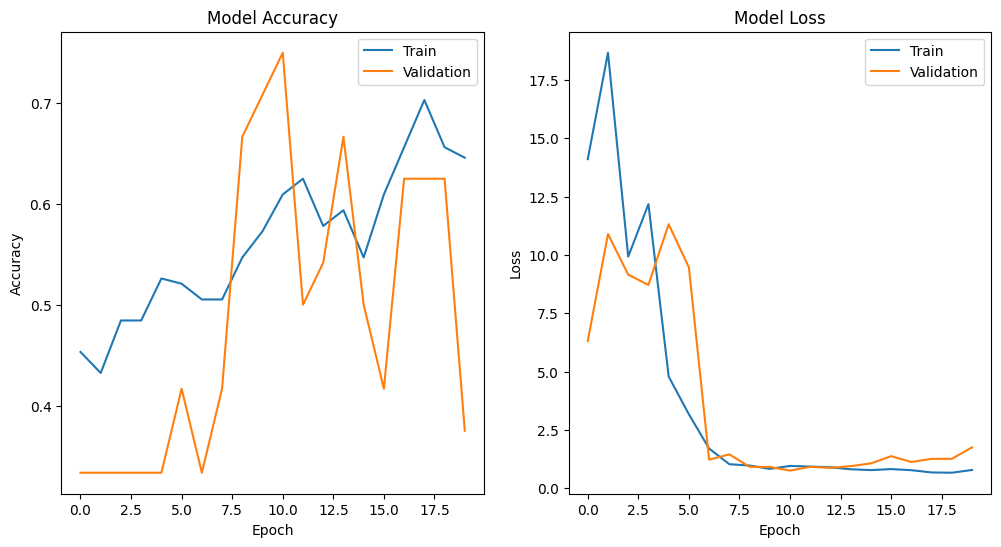

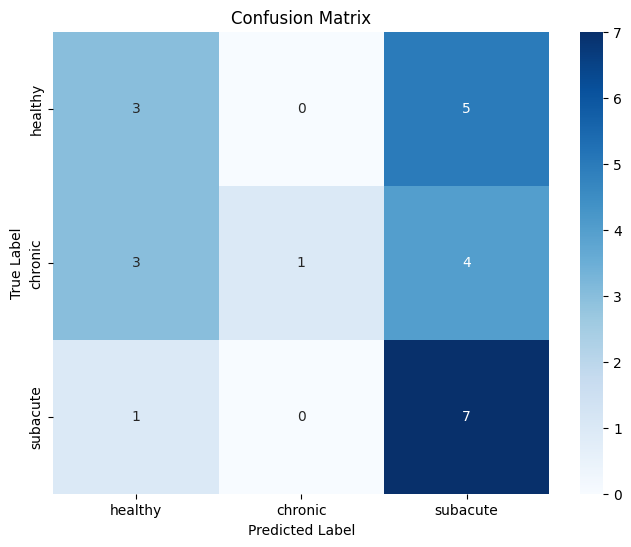

In [1]:
import os
import numpy as np
import nibabel as nib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Define the 3D-CNN model function
def build_3d_cnn(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    x = Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = BatchNormalization()(x)

    # Flatten and dense layers
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=[inputs], outputs=[outputs])

    return model

# Paths
base_dir = '/content/drive/My Drive/ChronicAI/dataset/TrainTestValSplit/'

splits = ['train', 'val', 'test']
groups = ['healthy', 'chronic', 'subacute']

def load_mri_data(base_dir, groups, splits):
    data = []
    labels = []
    for group_idx, group in enumerate(groups):
        for split in splits:
            split_dir = os.path.join(base_dir, group, split)
            for file_name in os.listdir(split_dir):
                if file_name.endswith('.nii'):
                    file_path = os.path.join(split_dir, file_name)
                    mri_image_nii = nib.load(file_path)
                    mri_image = mri_image_nii.get_fdata()
                    data.append(mri_image)
                    labels.append(group_idx)
    return np.array(data), np.array(labels)

# Load data
data, labels = load_mri_data(base_dir, groups, splits)

# Split data into train, validation, and test sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
val_data, test_data, val_labels, test_labels = train_test_split(test_data, test_labels, test_size=0.5, random_state=42, stratify=test_labels)

# Normalize data
train_data = (train_data - np.min(train_data)) / (np.max(train_data) - np.min(train_data))
val_data = (val_data - np.min(val_data)) / (np.max(val_data) - np.min(val_data))
test_data = (test_data - np.min(test_data)) / (np.max(test_data) - np.min(test_data))

# Add a channel dimension
train_data = np.expand_dims(train_data, axis=-1)
val_data = np.expand_dims(val_data, axis=-1)
test_data = np.expand_dims(test_data, axis=-1)

# Convert labels to categorical
train_labels = to_categorical(train_labels, num_classes=len(groups))
val_labels = to_categorical(val_labels, num_classes=len(groups))
test_labels = to_categorical(test_labels, num_classes=len(groups))

# Define and compile the model
input_shape = (128, 128, 128, 1)  # Adjust based on your input shape
num_classes = len(groups)
model = build_3d_cnn(input_shape, num_classes)
optimizer = Adam(learning_rate=1e-4)  # Adjust learning rate as needed
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data, train_labels, epochs=20, batch_size=2, validation_data=(val_data, val_labels))

# Evaluate the model
test_predictions = model.predict(test_data)
test_labels_pred = np.argmax(test_predictions, axis=1)
test_labels_true = np.argmax(test_labels, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_labels_true, test_labels_pred)
print('Confusion Matrix:\n', cm)

# F1 Score
f1 = f1_score(test_labels_true, test_labels_pred, average='weighted')
print('F1 Score:', f1)

# Classification Report
report = classification_report(test_labels_true, test_labels_pred, target_names=groups)
print('Classification Report:\n', report)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=groups, yticklabels=groups)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [2]:
model.save('3dcnn_model_3dMRIs.keras')